In [127]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [128]:
from ultralytics import YOLO
import numpy as np
import cv2
import easyocr
import matplotlib.pyplot as plt
import math
from wpodnet.backend import Predictor
from wpodnet.model import WPODNet
import torch
from PIL import Image

In [129]:
yolo_model = YOLO(verbose=True)

In [130]:
ocr_model = easyocr.Reader(["en"], verbose=True, model_storage_directory=".")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [131]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = WPODNet()
model.to(device)
checkpoint = torch.load('./wpodnet.pth')
model.load_state_dict(checkpoint)
wpod_model = Predictor(model)

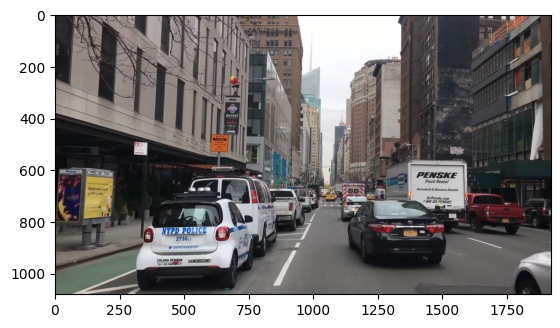

In [132]:
img = cv2.cvtColor(cv2.imread("./data/sample.png", cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
plt.imshow(img)

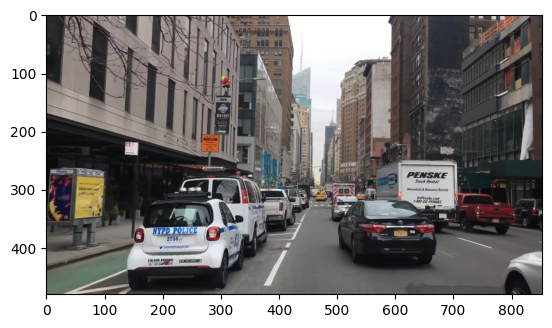

In [133]:
# Resize to 480p
(h, w) = img.shape[:2]
new_height = 480
aspect_ratio = w/h
new_width = int(new_height * aspect_ratio)
tmp_img = cv2.resize(img, (new_width, new_height))
plt.imshow(tmp_img)


0: 384x640 4 cars, 1 truck, 120.8ms
Speed: 2.0ms preprocess, 120.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'o

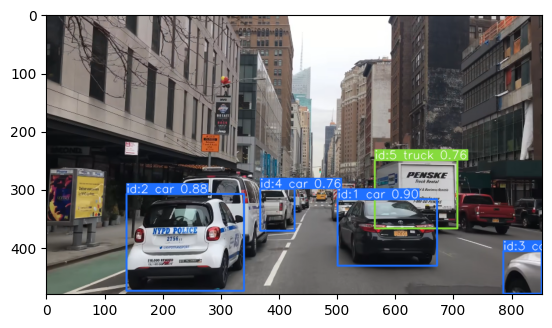

In [134]:
detect_results = yolo_model.track(tmp_img)
detect_img = detect_results[0].plot()
boxes = detect_results[0].boxes
plt.imshow(detect_img)
print(detect_results)
print(boxes[0])

In [135]:
n_fig = len(boxes)
vehicles_box = []
vehicles_id = []
for box in boxes:
    x0, y0, x1, y1 = box.xyxyn[0]
    vehicles_id.append(f"{box.id[0]}_{detect_results[0].names[int(round(box.cls[0].item()))]}")
    vehicles_box.append((x0, y0, x1, y1))

1127 1512 713 970
311 766 695 1068
1770 1919 914 1079
829 961 673 836
1273 1592 562 826


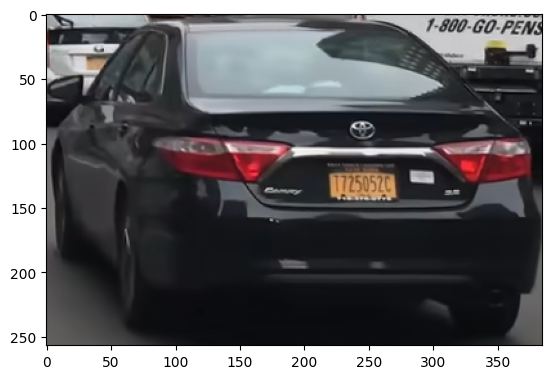

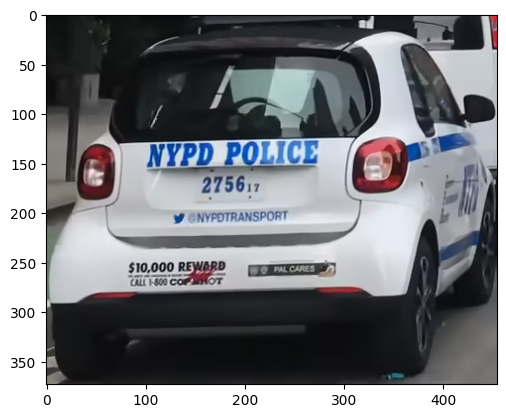

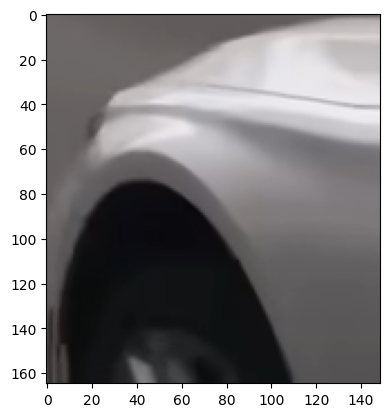

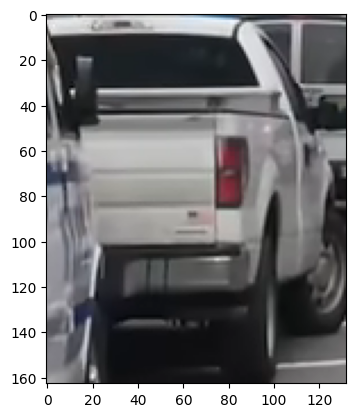

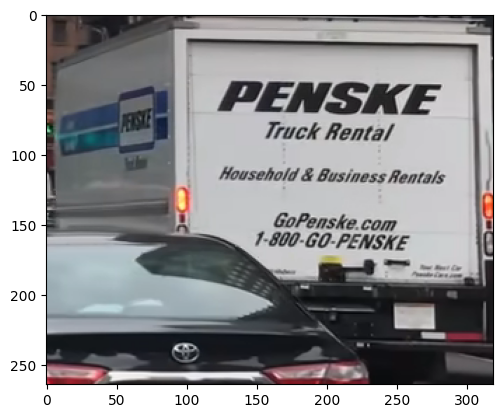

In [136]:
i = 0
vehicles_img = []
for box in vehicles_box:
    x0, y0, x1, y1 = box
    x0 = int(x0*w)
    x1 = int(x1*w)
    y0 = int(y0*h)
    y1 = int(y1*h)
    print(x0,x1,y0,y1)
    cropped = img[y0:y1,x0:x1]
    vehicles_img.append(cropped)
    plt.figure(i)
    plt.imshow(cropped)
    i += 1

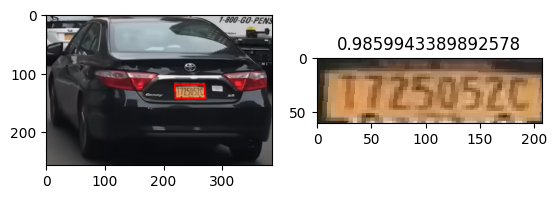

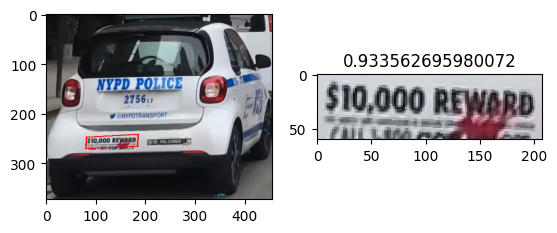

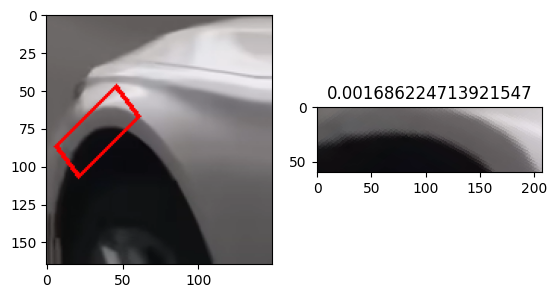

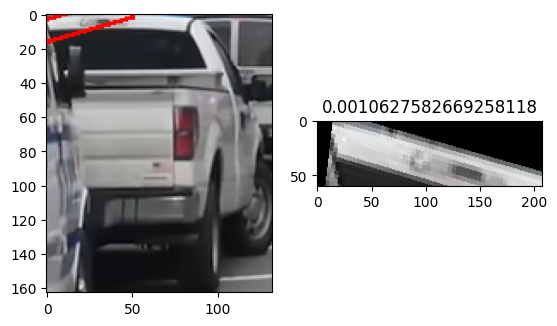

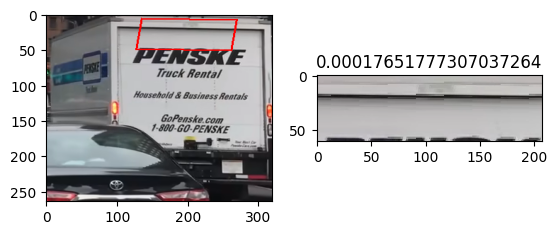

In [137]:
i = 0
plates = []
for v_img in vehicles_img:
    prediction = wpod_model.predict(Image.fromarray(np.uint8(v_img)).convert('RGB'))
    annotated = prediction.annotate()
    wrapped = prediction.warp()
    plt.figure(i)
    plt.subplot(1,2,1)
    plt.imshow(annotated)
    plt.subplot(1,2,2)
    plt.imshow(wrapped)
    plt.title(prediction.confidence)
    if prediction.confidence > 0.9:
        plates.append(np.array(wrapped))
    else:
        plates.append(v_img)
    i += 1

In [138]:
vehicles_iden = []
for v_img in plates:
    ocr_result = ocr_model.readtext(v_img, paragraph=True, detail=0)
    vehicles_iden.append("#&#".join(ocr_result)  if len(ocr_result) > 0 else "##&NOTEXT&##")

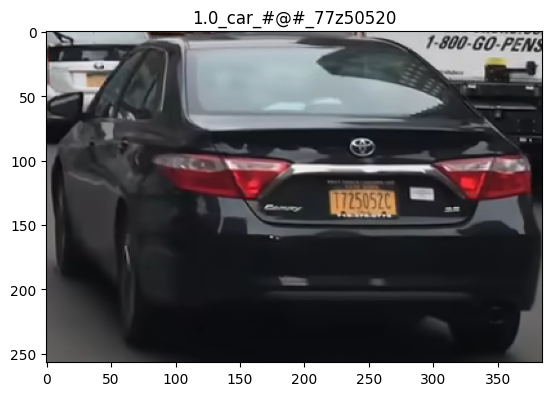

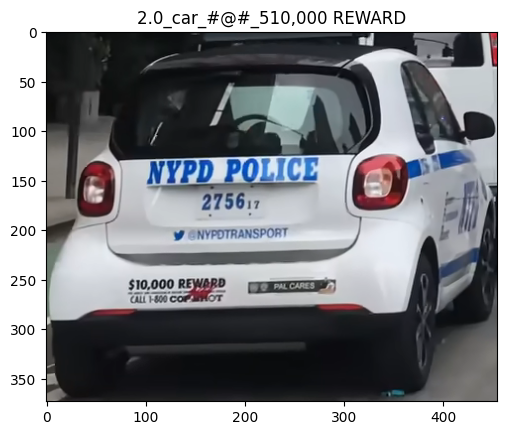

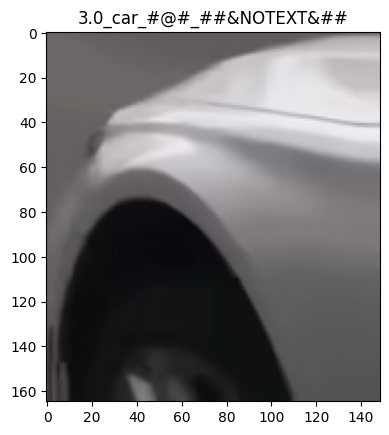

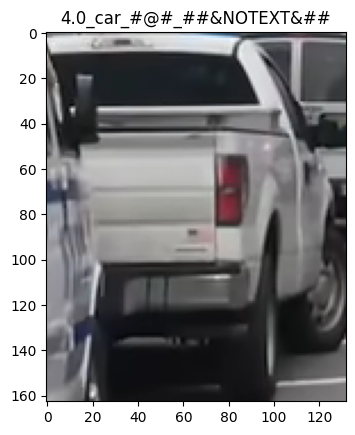

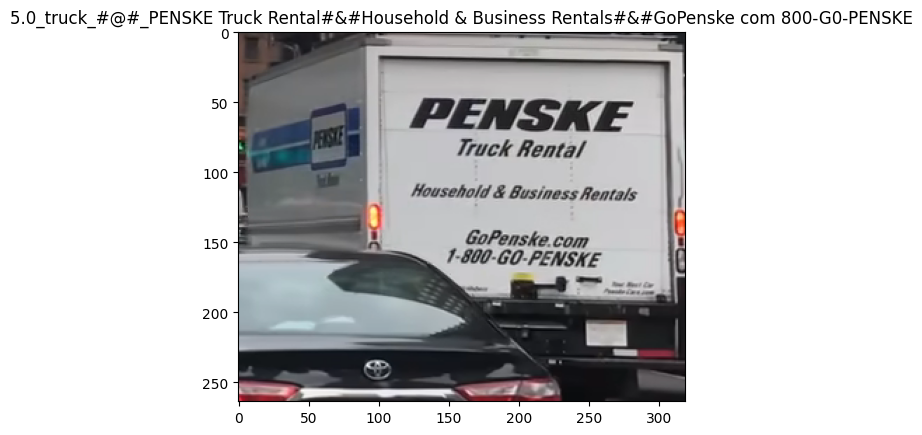

In [139]:
for i in range(n_fig):
    plt.figure(i)
    plt.imshow(vehicles_img[i])
    plt.title(f"{vehicles_id[i]}_#@#_{vehicles_iden[i]}")
    pass